# Train a 3D Convolutional Neural Network (3dCNN) to classify motor tasks

<p style='text-align: justify;'>In this notebook we create and train a 3D-Convolutional Neural Network which learns to classify different patterns of whole-brain fMRI statistical parameters (t-scores). In this first approach our goal is to train a classifier that can reliably distinguish between such whole-brain patterns for five limb movements (i.e., left/right hand, left/right foot, and tongue).

</p>

In [1]:
import os
import wandb
import torch
import pandas as pd
import numpy as np
import time
from delphi import mni_template
from glob import glob
from torch.utils.data import DataLoader
from torchinfo import summary

from delphi.networks.ConvNets import BrainStateClassifier3d
from delphi.utils.datasets import NiftiDataset
from delphi.utils.tools import ToTensor, compute_accuracy, convert_wandb_config, read_config, z_transform_volume
from delphi.utils.plots import confusion_matrix

from sklearn.model_selection import StratifiedShuffleSplit

DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

<p style='text-align: justify;'>To make sure that we obtain (almost) the same results for each execution we set the random seed of multiple different librabries (i.e., torch, random, numpy)</p>

In [2]:
def set_random_seed(seed):
    import random
    torch.backends.cudnn.benchmark = False
    torch.manual_seed(seed)
    random.seed(seed)
    np.random.seed(seed)
    g = torch.Generator()  # can be used in pytorch dataloaders for reproducible sample selection when shuffle=True
    g.manual_seed(seed)

    return g

g = set_random_seed(2020) # the project started in the year 2020, hence the seed

<p style='text-align: justify;'>We use a library called <a href="https://wandb.ai">weights and biases</a> to keep track of our networks performances and, as the name suggests, their weigths and biases. The function below uses some of its functionallity to print receiver-operating-characteristics, precision-recall, and confusion matrices. (See <a href="https://wandb.ai/philis893/thesis?workspace=user-philis893">https://wandb.ai/philis893/thesis?workspace=user-philis893)</a>
</p>

In [3]:
def wandb_plots(y_true, y_pred, y_prob, class_labels, dataset):
    r"""
    Function to plot receiver-operating-characteristics, precision-recall curves, and confusion matrices
    in the w&b online platform.
    
    Parameters
    ----------
    y_true: list of true labels
    y_pred: list of predicted labels
    y_prob: probability values of the network prediction
    class_labels: the names of the classes to predict
    dataset: string; name of the current dataset
    """
    wandb.log({
        f"{dataset}-ROC": wandb.plot.roc_curve(y_true=y_true, y_probas=y_prob, labels=class_labels, title=f"{dataset}-ROC"),
        f"{dataset}-PR": wandb.plot.pr_curve(y_true=y_true, y_probas=y_prob, labels=class_labels, title=f"{dataset}-PR"),
        f"{dataset}-ConfMat": wandb.plot.confusion_matrix(y_true=y_true, preds=y_pred, class_names=class_labels, title=f"{dataset}-ConfMat")
    })

In [4]:
def reset_wandb_env():
    exclude = {
        "WANDB_PROJECT",
        "WANDB_ENTITY",
        "WANDB_API_KEY",
    }
    for k, v in os.environ.items():
        if k.startswith("WANDB_") and k not in exclude:
            del os.environ[k]

## Initializations

In this section, we define and initialize our required variables. We first need to define which classes we want to predict, i.e., the conditions of the motor mapper. We then define a PyTorch dataset; in this case `NiftiDataset` is a custom written Dataset-Class (see https://github.com/PhilippS893/delphi). As is common practice in machine learning projects, we split our data into a training and validation dataset (ratio=80 to 20, respectively).

Note: In case it is necessary to create a null-model, i.e., a neural network that is trained on data where the labels are randomized, one can set the parameter `shuffe_labels=False` to `True`. This is usually done to have a baseline for the null hypothesis that "everything is random".

In [7]:
class_labels = sorted(["handleft", "handright", "footleft", "footright", "tongue"])

data_test = NiftiDataset("../t-maps/test", class_labels, 0, device=DEVICE, transform=ToTensor())

<p style='text-align: justify;'>We now set some parameters required by w&b to properly store information about our trained neural networks.</p>

In [ ]:
# set the wandb sweep config
# os.environ['WANDB_MODE'] = 'offline'
os.environ['WANDB_ENTITY'] = "philis893" # this is my wandb account name. This can also be a group name, for example
os.environ['WANDB_PROJECT'] = "thesis" # this is simply the project name where we want to store the sweep logs and plots

## Training the neural network(s)

<p style='text-align: justify;'>In this first approach, we estimated what parameters we could use for our 3d-CNN from existing literature. We make use of some functionality, e.g., the function "read_config", I wrote for the "delphi" toolbox (see https://github.com/PhilippS893/delphi). This function can read .yaml files with the formatting as below:</p>

The contents of `hyperparameter.yaml`: <br>
`kernel_size: 7`<br>
`batch_size: 4`<br>
`dropout: .5`<br>
`learning_rate: 0.00001`<br>
`epochs: 60`<br>
`channels: [1, 8, 16, 32, 64]`<br>
`lin_neurons: [128, 64]`<br>
`pooling_kernel: 2`<br>
`channels: [1, 8, 16, 32, 64]`<br>
`lin_neurons: [128, 64]`<br>
`pooling_kernel: 2`<br>

The function `read_config` will return a dictionary variable containing all keyword-value pairs as set in the `hyperparameter.yaml`. We do this, because the `delphi` toolbox was written with dictionaries as configuration variables in mind and because we can easily submit dictionaries to `w&b` to keep track of such parameters.

In [ ]:
def train_network(run, fold, data_train, data_valid, data_test, hp, class_labels, shuffled_labels=False):
    reset_wandb_env()
    
    job_name = "CV-motor-shuffled" if shuffled_labels else "CV-motor"
    wandb_kwargs = {
        "entity": os.environ['WANDB_ENTITY'],
        "project": os.environ['WANDB_PROJECT'],
        "group": "first-steps-motor",
        "name": f"motor-classifier_fold-{fold:02d}",
        "job_type": job_name if num_folds > 1 else "train",
    }
    
    save_name = os.path.join("models", job_name, wandb_kwargs["name"])
    if os.path.exists(save_name):
        return
    
    # we adjust the random seed here to ensure that each run of each fold has a unique seed!
    g = set_random_seed(2020 + fold + run)
    
    # we now use the wandb context to track the training and evaluation process.
    # all settings and changes will be reset at the beginning of the fold-loop. (see line 11)
    with wandb.init(config=hp, **wandb_kwargs) as run:
        
        # please note that this conversion is unnecessary if not using w&b!
        model_cfg = convert_wandb_config(run.config, BrainStateClassifier3d._REQUIRED_PARAMS)
        
        # setup a model with the parameters given in model_cfg
        model = BrainStateClassifier3d(input_dims, len(class_labels), model_cfg)
        model.to(DEVICE);
        
        dl_train = DataLoader(data_train, batch_size=run.config.batch_size, shuffle=True, generator=g)
        dl_valid = DataLoader(data_valid, batch_size=run.config.batch_size, shuffle=True, generator=g)
        dl_test = DataLoader(data_test, batch_size=run.config.batch_size, shuffle=False, generator=g)

        best_loss, best_acc = 100, 0
        loss_acc = []
        train_stats, valid_stats = [], []

        # loop for the above set number of epochs
        for epoch in range(run.config.epochs):
            _, _ = model.fit(dl_train, lr=run.config.learning_rate, device=DEVICE)

            # for validating or testing set the network into evaluation mode such that layers like dropout are not active
            with torch.no_grad():
                tloss, tstats = model.fit(dl_train, device=DEVICE, train=False)
                vloss, vstats = model.fit(dl_valid, device=DEVICE, train=False)

            # the model.fit() method has 2 output parameters: loss, stats = model.fit()
            # the first parameter is simply the loss for each sample
            # the second parameter is a matrix of n_classes+2-by-n_samples
            # the first n_classes columns are the output probabilities of the model per class
            # the second to last column (i.e., [:, -2]) represents the real labels
            # the last column (i.e., [:, -1]) represents the predicted labels
            tacc = compute_accuracy(tstats[:, -2], tstats[:, -1])
            vacc = compute_accuracy(vstats[:, -2], vstats[:, -1])

            loss_acc.append(pd.DataFrame([[tloss, vloss, tacc, vacc]],
                                         columns=["train_loss", "valid_loss", "train_acc", "valid_acc"]))

            train_stats.append(pd.DataFrame(tstats.tolist(), columns=[*class_labels, *["real", "predicted"]]))
            train_stats[epoch]["epoch"] = epoch
            valid_stats.append(pd.DataFrame(vstats.tolist(), columns=[*class_labels, *["real", "predicted"]]))
            valid_stats[epoch]["epoch"] = epoch

            wandb.log({
                "train_acc": tacc, "train_loss": tloss,
                "valid_acc": vacc, "valid_loss": vloss
            }, step=epoch)

            print('Epoch=%03d, train_loss=%2.3f, train_acc=%1.3f, valid_loss=%2.3f, valid_acc=%1.3f' % 
                 (epoch, tloss, tacc, vloss, vacc))

            if (vacc >= best_acc) and (vloss <= best_loss):
                # assign the new best values
                best_acc, best_loss = vacc, vloss
                wandb.run.summary["best_valid_accuracy"] = best_acc
                wandb.run.summary["best_valid_epoch"] = epoch
                # save the current best model
                model.save(save_name)
                # plot some graphs for the validation data
                wandb_plots(vstats[:, -2], vstats[:, -1], vstats[:, :-2], class_labels, "valid")


        # save the files
        full_df = pd.concat(loss_acc)
        full_df.to_csv(os.path.join(save_name, "loss_acc_curves.csv"), index=False)
        full_df = pd.concat(train_stats)
        full_df.to_csv(os.path.join(save_name, "train_stats.csv"), index=False)
        full_df = pd.concat(valid_stats)
        full_df.to_csv(os.path.join(save_name, "valid_stats.csv"), index=False)

        # EVALUATE THE MODEL ON THE TEST DATA
        with torch.no_grad():
            testloss, teststats = model.fit(dl_test, train=False)
        testacc = compute_accuracy(teststats[:, -2], teststats[:, -1])
        wandb.run.summary["test_accuracy"] = testacc

        wandb.log({"test_accuracy": testacc, "test_loss": testloss})
        wandb_plots(teststats[:, -2], teststats[:, -1], teststats[:, :-2], class_labels, "test")

        wandb.finish()

In [ ]:
hp = read_config("hyperparameter.yaml")

num_folds = 10 # we decided to run a 10-fold cross-validation scheme
run = 0 # in case you decide to do multiple runs of the cross-validation scheme
input_dims = (91, 109, 91) # these are the 3D input dimension of our whole-brain data

### Run cross-validation training using correct labels

In [ ]:
# we will split the train dataset into a train (80%) and validation (20%) set.
data_train_full = NiftiDataset("../t-maps/train", class_labels, 0, device=DEVICE, 
                               transform=ToTensor(), shuffle_labels=False)

# we want a stratified shuffled split
sss = StratifiedShuffleSplit(n_splits=num_folds, test_size=0.2, random_state=2020)

for fold, (idx_train, idx_valid) in enumerate(sss.split(data_train_full.data, data_train_full.labels)):
    data_train = torch.utils.data.Subset(data_train_full, idx_train)
    data_valid = torch.utils.data.Subset(data_train_full, idx_valid)
    train_network(run, fold, data_train, data_valid, data_test, hp, class_labels)

### Run cross-validation training using shuffled labels

In [ ]:
# we will split the train dataset into a train (80%) and validation (20%) set.
data_train_full = NiftiDataset("../t-maps/train", class_labels, 20, device=DEVICE, 
                               transform=ToTensor(), shuffle_labels=True)

# we want a stratified shuffled split
sss = StratifiedShuffleSplit(n_splits=num_folds, test_size=0.2, random_state=2020)

for fold, (idx_train, idx_valid) in enumerate(sss.split(data_train_full.data, data_train_full.labels)):
    data_train = torch.utils.data.Subset(data_train_full, idx_train)
    data_valid = torch.utils.data.Subset(data_train_full, idx_valid)
    train_network(run, fold, data_train, data_valid, data_test, hp, class_labels, shuffled_labels=True)

## Analyzing the network performances

### OLD

In [ ]:
hp = read_config("hyperparameter.yaml")

num_folds = 10 # we decided to run a 10-fold cross-validation scheme
run = 0 # in case you decide to do multiple runs of the cross-validation scheme
input_dims = (91, 109, 91) # these are the 3D input dimension of our whole-brain data

# we want one stratified shuffled split
sss = StratifiedShuffleSplit(n_splits=num_folds, test_size=0.2, random_state=2020)

for fold, (idx_train, idx_valid) in enumerate(sss.split(data_train_full.data, data_train_full.labels)):
    reset_wandb_env()
    wandb_kwargs = {
        "entity": os.environ['WANDB_ENTITY'],
        "project": os.environ['WANDB_PROJECT'],
        "group": "first-steps-motor",
        "name": f"motor-classifier_fold-{fold:02d}",
        "job_type": "CV-motor" if num_folds > 1 else "train",
    }

    data_train = torch.utils.data.Subset(data_train_full, idx_train)
    data_valid = torch.utils.data.Subset(data_train_full, idx_valid)
    
    save_name = os.path.join("models", wandb_kwargs["name"])
    if os.path.exists(save_name):
        continue
    
    # we adjust the random seed here to ensure that each run of each fold has a unique seed!
    g = set_random_seed(2020 + fold + run)
    
    # we now use the wandb context to track the training and evaluation process.
    # all settings and changes will be reset at the beginning of the fold-loop. (see line 11)
    with wandb.init(config=hp, **wandb_kwargs) as run:
        
        # please note that this conversion is unnecessary if not using w&b!
        model_cfg = convert_wandb_config(run.config, BrainStateClassifier3d._REQUIRED_PARAMS)
        
        # setup a model with the parameters given in model_cfg
        model = BrainStateClassifier3d(input_dims, len(class_labels), model_cfg)
        model.to(DEVICE);
        
        dl_train = DataLoader(data_train, batch_size=run.config.batch_size, shuffle=True, generator=g)
        dl_valid = DataLoader(data_valid, batch_size=run.config.batch_size, shuffle=True, generator=g)
        dl_test = DataLoader(data_test, batch_size=run.config.batch_size, shuffle=False, generator=g)

        best_loss, best_acc = 100, 0
        loss_acc = []
        train_stats, valid_stats = [], []

        # loop for the above set number of epochs
        for epoch in range(run.config.epochs):
            _, _ = model.fit(dl_train, lr=run.config.learning_rate, device=DEVICE)

            # for validating or testing set the network into evaluation mode such that layers like dropout are not active
            with torch.no_grad():
                tloss, tstats = model.fit(dl_train, device=DEVICE, train=False)
                vloss, vstats = model.fit(dl_valid, device=DEVICE, train=False)

            # the model.fit() method has 2 output parameters: loss, stats = model.fit()
            # the first parameter is simply the loss for each sample
            # the second parameter is a matrix of n_classes+2-by-n_samples
            # the first n_classes columns are the output probabilities of the model per class
            # the second to last column (i.e., [:, -2]) represents the real labels
            # the last column (i.e., [:, -1]) represents the predicted labels
            tacc = compute_accuracy(tstats[:, -2], tstats[:, -1])
            vacc = compute_accuracy(vstats[:, -2], vstats[:, -1])

            loss_acc.append(pd.DataFrame([[tloss, vloss, tacc, vacc]],
                                         columns=["train_loss", "valid_loss", "train_acc", "valid_acc"]))

            train_stats.append(pd.DataFrame(tstats.tolist(), columns=[*class_labels, *["real", "predicted"]]))
            train_stats[epoch]["epoch"] = epoch
            valid_stats.append(pd.DataFrame(vstats.tolist(), columns=[*class_labels, *["real", "predicted"]]))
            valid_stats[epoch]["epoch"] = epoch

            wandb.log({
                "train_acc": tacc, "train_loss": tloss,
                "valid_acc": vacc, "valid_loss": vloss
            }, step=epoch)

            print('Epoch=%03d, train_loss=%2.3f, train_acc=%1.3f, valid_loss=%2.3f, valid_acc=%1.3f' % 
                 (epoch, tloss, tacc, vloss, vacc))

            if (vacc >= best_acc) and (vloss <= best_loss):
                # assign the new best values
                best_acc, best_loss = vacc, vloss
                wandb.run.summary["best_valid_accuracy"] = best_acc
                wandb.run.summary["best_valid_epoch"] = epoch
                # save the current best model
                model.save(save_name)
                # plot some graphs for the validation data
                wandb_plots(vstats[:, -2], vstats[:, -1], vstats[:, :-2], class_labels, "valid")


        # save the files
        full_df = pd.concat(loss_acc)
        full_df.to_csv(os.path.join(save_name, "loss_acc_curves.csv"), index=False)
        full_df = pd.concat(train_stats)
        full_df.to_csv(os.path.join(save_name, "train_stats.csv"), index=False)
        full_df = pd.concat(valid_stats)
        full_df.to_csv(os.path.join(save_name, "valid_stats.csv"), index=False)

        # EVALUATE THE MODEL ON THE TEST DATA
        with torch.no_grad():
            testloss, teststats = model.fit(dl_test, train=False)
        testacc = compute_accuracy(teststats[:, -2], teststats[:, -1])
        wandb.run.summary["test_accuracy"] = testacc

        wandb.log({"test_accuracy": testacc, "test_loss": testloss})
        wandb_plots(teststats[:, -2], teststats[:, -1], teststats[:, :-2], class_labels, "test")

        wandb.finish()

## Investigate what information was deemed relevant (XAI)
### Run the Layer-wise Relevance Propagation (LRP) algorithm

In [5]:
from delphi.utils.tools import save_in_mni
from zennit import composites

In [28]:
# Execute the LRP algorithm and save the resulting LRP maps somewhere.
shape = (1, 1, 91, 109, 91)

composite_kwargs = {
    'low': -5 * torch.ones(*shape, device=torch.device("cpu")),  # the lowest and ...
    'high': 5 * torch.ones(*shape, device=torch.device("cpu")),  # the highest pixel value for ZBox
}
# In this line I am telling zennit what kind of rule I want to use and supply
# some arguments. 
attributor = composites.COMPOSITES['epsilon_gamma_box'](**composite_kwargs)

#for param in model.parameters():
#    param.requires_grad = False


for fold in range(10):
# load the trained network
    model = BrainStateClassifier3d(f"models/CV-motor/motor-classifier_fold-{fold:02d}")
    model.eval()
    model.to(torch.device("cpu"));

    out_dir_name = f"lrp/epsgamma_fold-{fold:02d}"
    if not os.path.exists(out_dir_name):
        os.mkdir(out_dir_name)

    for j in range(len(class_labels)):

        print(f"Running LRP on {class_labels[j]}")
        
        out_fname = os.path.join(out_dir_name, '%s_test.nii.gz' % class_labels[j])
        if os.path.isfile(out_fname):
            print(f"{out_fname} already exists. Skipping")
            continue
        
        dl = DataLoader(
            NiftiDataset('../t-maps/test', [class_labels[j]], 0, device=torch.device("cpu"), transform=ToTensor()),
            batch_size=20, shuffle=False, num_workers=0
        )

        for i, (volume, target) in enumerate(dl):

            volume.requires_grad = True
            grad_dummy = torch.eye(model.config['n_classes'], device=torch.device("cpu"))[target]

            with attributor.context(model) as modified_model:

                output = modified_model(volume)
                attribution, = torch.autograd.grad(output, volume, grad_outputs=grad_dummy)
                subject_lrp = np.moveaxis(attribution.squeeze().detach().numpy(), 0, -1)
                subject_lrp = z_transform_volume(subject_lrp)
                avg_lrp = subject_lrp.mean(axis=-1)

        save_in_mni(subject_lrp, out_fname)
        #save_in_mni(avg_lrp, os.path.join(out_dir_name, 'avg_%s_test.nii.gz' % class_labels[j]))
        

Loading from config file models/CV-motor/motor-classifier_fold-00/config.yaml
Running LRP on footleft
lrp/epsgamma_fold-00/footleft_test.nii.gz already exists. Skipping
Running LRP on footright
lrp/epsgamma_fold-00/footright_test.nii.gz already exists. Skipping
Running LRP on handleft
lrp/epsgamma_fold-00/handleft_test.nii.gz already exists. Skipping
Running LRP on handright
lrp/epsgamma_fold-00/handright_test.nii.gz already exists. Skipping
Running LRP on tongue
lrp/epsgamma_fold-00/tongue_test.nii.gz already exists. Skipping
Loading from config file models/CV-motor/motor-classifier_fold-01/config.yaml
Running LRP on footleft
Saving lrp/epsgamma_fold-01/footleft_test.nii.gz
Running LRP on footright
Saving lrp/epsgamma_fold-01/footright_test.nii.gz
Running LRP on handleft
Saving lrp/epsgamma_fold-01/handleft_test.nii.gz
Running LRP on handright
Saving lrp/epsgamma_fold-01/handright_test.nii.gz
Running LRP on tongue
Saving lrp/epsgamma_fold-01/tongue_test.nii.gz
Loading from config file

KeyboardInterrupt: 

In [30]:
# let us visualize the average LRP maps
# Brain_Data from the nltools toolbox allows us to visualize brain maps quit nicely
from nltools.data import Brain_Data

#files = sorted(glob(f"motor-mapper-lrp-epsgamma/handleft.nii.gz"))
fold = 1
files = sorted(glob(f"lrp/epsgamma_fold-{fold:02d}/handleft_test.nii.gz"))
dat = Brain_Data(files)
dat.iplot()

interactive(children=(FloatText(value=0.0, description='Threshold'), IntSlider(value=0, continuous_update=Fals…

# SecondLevel GLM analyses

In [18]:
import matplotlib.pyplot as plt
import nilearn
from nilearn.image import load_img
from nilearn.glm.second_level import SecondLevelModel
import nibabel as nib

In [19]:
# load the real images
test_img_files = []
[test_img_files.extend(sorted(glob(f"../copes/test/{class_labels[i]}/*.nii.gz"))) for i in range(len(class_labels))]
images = load_img(test_img_files)
real = np.repeat([0,1,2,3,4], 20)

# load the relevance images
fold = 0
relevance_files = sorted(glob(f"lrp/epsgamma_fold-{fold:02d}/*_test.nii.gz"))
print(relevance_files)
relevance_maps = load_img(relevance_files)

mask = load_img(mni_template)

['lrp/epsgamma_fold-00/footleft_test.nii.gz', 'lrp/epsgamma_fold-00/footright_test.nii.gz', 'lrp/epsgamma_fold-00/handleft_test.nii.gz', 'lrp/epsgamma_fold-00/handright_test.nii.gz', 'lrp/epsgamma_fold-00/tongue_test.nii.gz']


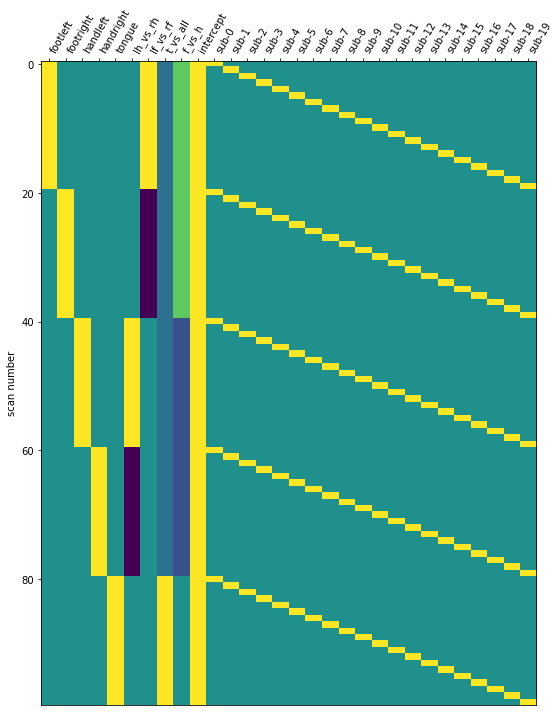

In [20]:
from nilearn.plotting import plot_design_matrix, plot_contrast_matrix
n_subs = 20
n = len(test_img_files)
design_matrix = {}

for label in range(len(class_labels)):
    regressor = np.repeat(np.eye(len(class_labels))[label], n_subs)
    design_matrix[f'{class_labels[label]}'] = regressor
               
design_matrix['lh_vs_rh'] = np.repeat([0, 0, 1, -1, 0], n_subs)
design_matrix['lf_vs_rf'] = np.repeat([1, -1, 0, 0, 0], n_subs)
design_matrix['t_vs_all'] = np.repeat([-.25, -.25, -.25, -.25, 1], n_subs)
design_matrix['f_vs_h'] = np.repeat([.5, .5, -.5, -.5, 0], n_subs)
design_matrix['intercept'] = np.ones(n)

for sub in range(n_subs):
    regressor = np.tile(np.eye(n_subs)[sub], len(class_labels))
    design_matrix[f'sub-{sub}'] = regressor

df_design_matrix = pd.DataFrame(design_matrix)
plot_design_matrix(df_design_matrix, rescale=False);

In [22]:
glm_orig = SecondLevelModel(smoothing_fwhm=None, mask_img=mask)
glm_orig.fit([nilearn.image.index_img(images, i) for i in range(n)], design_matrix=df_design_matrix)

glm_lrp = SecondLevelModel(smoothing_fwhm=None, mask_img=mask)
glm_lrp.fit([nilearn.image.index_img(relevance_maps , i) for i in range(n)], design_matrix=df_design_matrix)

SecondLevelModel(mask_img=<nibabel.nifti1.Nifti1Image object at 0x7fd1ba751130>)

In [23]:
def save_stat_maps(data, prefix, save_loc='stat-maps'):
    keys_of_interest = ["z_score", "stat", "effect_size"]
    for i, key in enumerate(keys_of_interest):
        path2save = os.path.join(save_loc, f"{prefix}_{key}.nii.gz")
        nib.save(data[key], path2save)

/Users/phisei/opt/anaconda3/envs/delphi/lib/python3.8/site-packages/nilearn/_utils/glm.py:335: RuntimeWarning: divide by zero encountered in true_divide
  return np.where(X <= 0, 0, 1. / X)


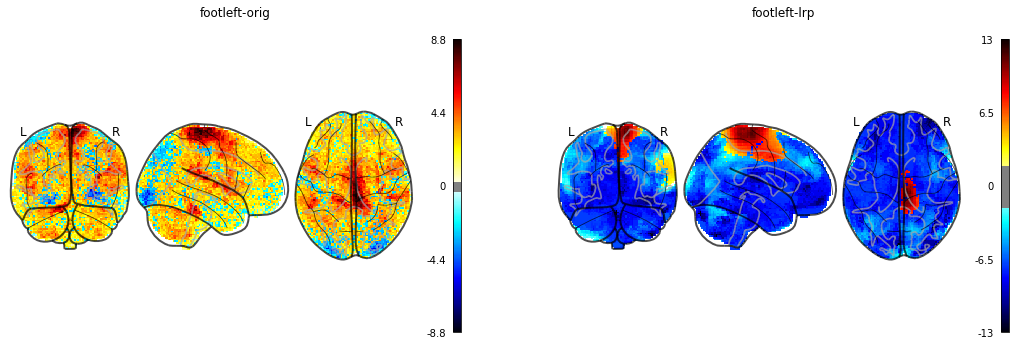

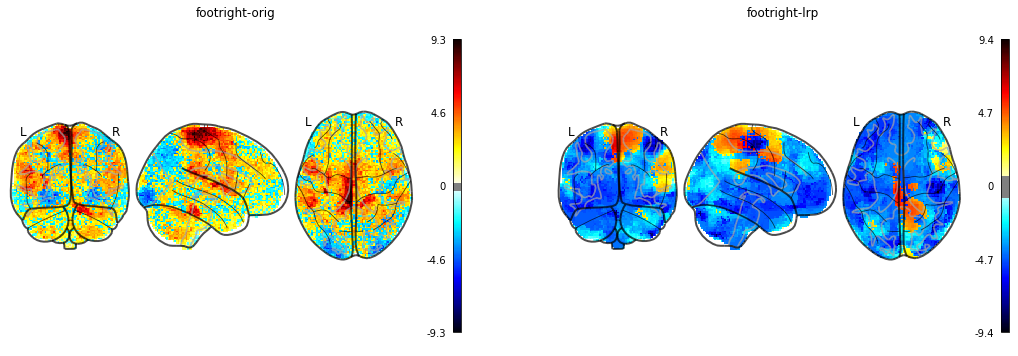

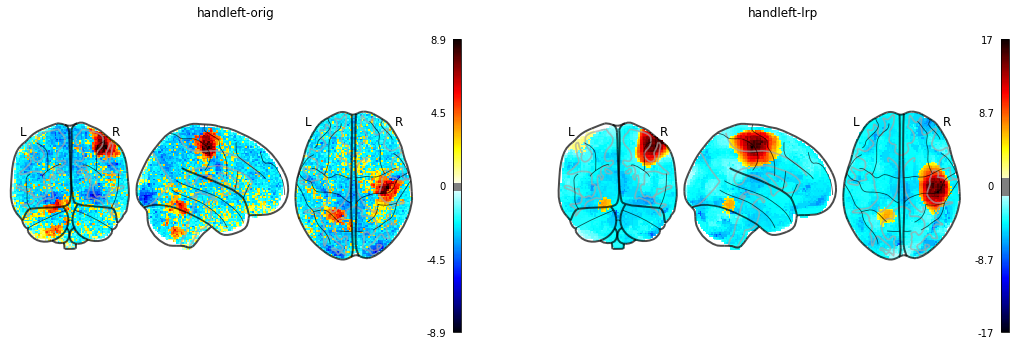

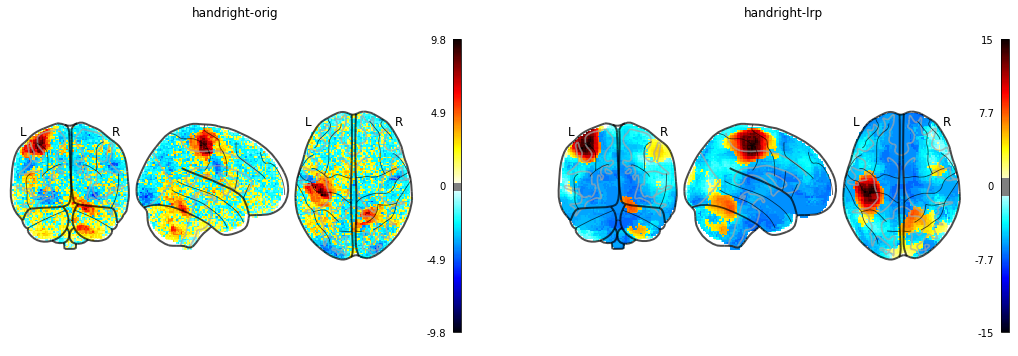

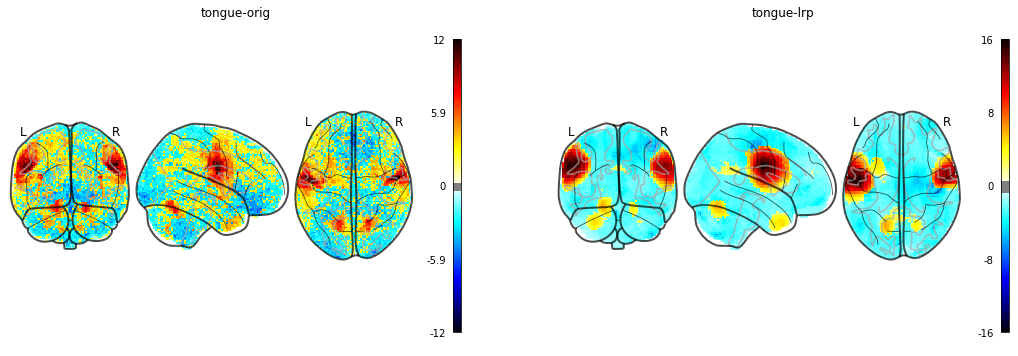

In [24]:
contrasts = ["footleft", "footright", "handleft", "handright", "tongue"]
#"lh_vs_rh", "lf_vs_rf", "t_vs_all", "f_vs_h"]

for c, contrast in enumerate(contrasts):
    maps_orig = glm_orig.compute_contrast(contrast, output_type="all")
    save_stat_maps(maps_orig, f"orig-{contrast}")
    maps_lrp = glm_lrp.compute_contrast(contrast, output_type="all")
    save_stat_maps(maps_lrp, f"lrp-fold-{fold:02d}-{contrast}")

    fig, axes = plt.subplots(1,2,figsize=(18,6))
    nilearn.plotting.plot_glass_brain(maps_orig['z_score'], colorbar=True, plot_abs=False, axes=axes[0]);
    axes[0].set_title(f"{contrast}-orig")
    nilearn.plotting.plot_glass_brain(maps_lrp['z_score'], colorbar=True, plot_abs=False, axes=axes[1]);
    axes[1].set_title(f"{contrast}-lrp")

In [25]:
sorted(glob(f"stat-maps/lrp-fold-{fold:02d}-*_z_score.nii.gz"))

['stat-maps/lrp-fold-00-footleft_z_score.nii.gz',
 'stat-maps/lrp-fold-00-footright_z_score.nii.gz',
 'stat-maps/lrp-fold-00-handleft_z_score.nii.gz',
 'stat-maps/lrp-fold-00-handright_z_score.nii.gz',
 'stat-maps/lrp-fold-00-tongue_z_score.nii.gz']

In [26]:
test = Brain_Data(sorted(glob(f"stat-maps/lrp-fold-{fold:02d}-*_z_score.nii.gz")), mask=mask)
test.iplot()

interactive(children=(FloatText(value=0.0, description='Threshold'), IntSlider(value=0, continuous_update=Fals…

In [27]:
test = Brain_Data(sorted(glob("stat-maps/orig-*_z_score.nii.gz")), mask=mask)
test.iplot()

interactive(children=(FloatText(value=0.0, description='Threshold'), IntSlider(value=0, continuous_update=Fals…

## SANITY CHECKS FOR RELEVANCE/XAI
### OCCLUSION (faithfulness test)

In [ ]:
from delphi.utils.tools import occlude_images

In [ ]:
percentages = np.concatenate([
    np.arange(0, 2, .2),
    np.arange(2, 5, .5),
    np.arange(5, 10, 1),
    np.arange(10, 32, 2)
])
accs = np.zeros((8, len(percentages)))
n_voxel = np.zeros_like(percentages)


for fold in range(2):
    # load the trained network
    model = BrainStateClassifier3d(f"models/CV-motor/motor-classifier_fold-{fold:02d}")
    model.eval()
    model.to(torch.device("cpu"));
    
    relevance_files = sorted(glob(f"lrp/epsgamma_fold-{fold:02d}/*nii.gz"))
    relevance_maps = load_img(relevance_files)

    for i, frac in enumerate(percentages):
        print(fold, i)
        occluded = occlude_images(images, relevance_maps, mask, fraction=frac, get_fdata=True)
        occluded = np.moveaxis(occluded, -1, 0)
        occluded = torch.tensor(occluded).unsqueeze(1)
        pred = np.argmax(model(occluded.float()).detach().cpu().numpy(), axis=1)
        accs[fold, i] = compute_accuracy(real, pred)

In [ ]:
mean_acc = accs[:7].mean(axis=0)
sd_acc = accs[:7].std(axis=0)
fig, ax = plt.subplots(figsize=(20, 8))
ax.errorbar(np.log(percentages), mean_acc, yerr=sd_acc, marker="o", linewidth=3, capsize=5, capthick=2);
ax.scatter(np.repeat(np.log(percentages), 7), accs[:7].transpose(), marker="o", alpha=.2, color="black");
ax.set_xticks(np.log(percentages)), ax.set_xticklabels(percentages)
ax.hlines(.2, ax.get_xlim()[0], ax.get_xlim()[1], color="black", linestyle="--")
ax.set_title('Occlusion effect'), ax.set_xlabel('Percent occlusion'), ax.set_ylabel('accuracy')
ax.spines['top'].set_visible(False), ax.spines['right'].set_visible(False);